In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import yaml
from astropy.wcs import wcs
from astropy.table import Table
import os
from astropy.wcs import WCS


In [2]:
# platescale to convert fiber positions from mm to arcsec
PLATESCALE = 112.36748321030637

# directory where reduced cFrames are stored
#DIR_redux = '/data/LVM/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/'
DIR_redux = 'data/'
DIR_agcam = '/data/LVM/sdsswork/data/agcam/lco/'

In [55]:
def rotate(xx,yy,angle):
    # rotate x and y cartesian coordinates by angle (in degrees)
    # about the point (0,0)
    theta = -1.*angle * np.pi / 180. # in radians
    xx1 = np.cos(theta) * xx - np.sin(theta) * yy
    yy1 = np.sin(theta) * xx + np.cos(theta) * yy
    return xx1, yy1

def make_radec(xx0,yy0,ra,dec,pa):
    xx, yy = rotate(xx0,yy0,pa)
    ra_fib = ra + xx*PLATESCALE/3600./np.cos(dec*np.pi/180.) 
    dec_fib = dec - yy*PLATESCALE/3600. 
    return ra_fib, dec_fib

    
def make_line(wave, r1, sci, wl_shift_vel, whichone):

    # Halpha
    wl_ha = (wave > 6560 + wl_shift_vel/3e5*6560) & (wave < 6570+ wl_shift_vel/3e5*6570)
    iis_ha = np.where(wl_ha)[0]
    ha = np.sum(r1[:,iis_ha],axis=1)[sci]

    wl_ha_cont = (wave > 6600+ wl_shift_vel/3e5*6600) & (wave < 6610+ wl_shift_vel/3e5*6610)
    iis_ha_cont = np.where(wl_ha_cont)[0]
    ha_cont = np.sum(r1[:,iis_ha_cont],axis=1)[sci]
        
        
    # SII doublet

    wl_sii1 = (wave > 6715+ wl_shift_vel/3e5*6715) & (wave < 6725+ wl_shift_vel/3e5*6725)
    iis_sii1 = np.where(wl_sii1)[0]
    sii1 = np.sum(r1[:,iis_sii1],axis=1)[sci]

    wl_sii2 = (wave > 6730+ wl_shift_vel/3e5*6730) & (wave < 6740+ wl_shift_vel/3e5*6740)
    iis_sii2 = np.where(wl_sii2)[0]
    sii2 = np.sum(r1[:,iis_sii2],axis=1)[sci]


    wl_sii_cont = (wave > 6700+ wl_shift_vel/3e5*6700) & (wave < 6710+ wl_shift_vel/3e5*6710)
    iis_sii_cont = np.where(wl_sii_cont)[0]
    sii_cont = np.sum(r1[:,iis_sii_cont],axis=1)[sci]
        
        
    # [SIII]9069

    wl_siii9068 = (wave > 9065+ wl_shift_vel/3e5*9065) & (wave < 9075+ wl_shift_vel/3e5*9075)
    iis_siii9068 = np.where(wl_siii9068)[0]
    siii9068 = np.sum(r1[:,iis_siii9068],axis=1)[sci]
    
    # [OIII]5007
    wl_oiii = (wave > 5000 + wl_shift_vel/3e5*5000) & (wave < 5015+ wl_shift_vel/3e5*5015)
    iis_oiii = np.where(wl_oiii)[0]
    oiii = np.sum(r1[:,iis_oiii],axis=1)[sci]
    
    
    # [OIII]4363    
    wl_oiii4363 = (wave > 4360 + wl_shift_vel/3e5*4360) & (wave < 4365+ wl_shift_vel/3e5*4365)
    iis_oiii4363 = np.where(wl_oiii4363)[0]
    oiii4363 = np.sum(r1[:,iis_oiii4363],axis=1)[sci]

    wl_oiii4363_cont = (wave > 4375+ wl_shift_vel/3e5*4375) & (wave < 4380+ wl_shift_vel/3e5*4380)
    iis_oiii4363_cont = np.where(wl_oiii4363_cont)[0]
    oiii4363_cont = np.sum(r1[:,iis_oiii4363_cont],axis=1)[sci]
   
    # [OII]3727
    wl_oii = (wave > 3720 + wl_shift_vel/3e5*3720) & (wave < 3732+ wl_shift_vel/3e5*3732)
    iis_oii = np.where(wl_oii)[0]
    oii = np.sum(r1[:,iis_oii],axis=1)[sci]
    
    #[NII]5755
    wl_nii5755 = (wave > 5752 + wl_shift_vel/3e5*5752) & (wave < 5758+ wl_shift_vel/3e5*5758)
    iis_nii5755 = np.where(wl_nii5755)[0]
    nii5755 = np.sum(r1[:,iis_nii5755],axis=1)[sci]

    wl_nii5755_cont = (wave > 5710+ wl_shift_vel/3e5*5710) & (wave < 5715+ wl_shift_vel/3e5*5715)
    iis_nii5755_cont = np.where(wl_nii5755_cont)[0]
    nii5755_cont = np.sum(r1[:,iis_nii5755_cont],axis=1)[sci]
    
    wl_nii5755_cont2 = (wave > 5770+ wl_shift_vel/3e5*5770) & (wave < 5775+ wl_shift_vel/3e5*5775)
    iis_nii5755_cont2 = np.where(wl_nii5755_cont2)[0]
    nii5755_cont2 = np.sum(r1[:,iis_nii5755_cont2],axis=1)[sci]
   
    #r band
    wl_r = (wave > 5500 + wl_shift_vel/3e5*5500) & (wave < 6900+ wl_shift_vel/3e5*6900)
    iis_r = np.where(wl_r)[0]
    r = np.sum(r1[:,iis_r],axis=1)[sci]


    if whichone == 'ha':
        return ha
    if whichone == 'ha_sub':
        return ha - ha_cont
    if whichone == 'sii':
        return sii1 + sii2
    if whichone == 'sii_ratio':
        ratio = sii1/sii2
        ratio[sii1+sii2 < 10] = np.nan
        return ratio
    if whichone == 'siii':
        return siii9068
    
    if whichone == 'oiii': 
        return oiii
    
    if whichone == 'oii':
        return oii
    
    if whichone == 'oiii4363':
        return oiii4363 - oiii4363_cont
    
    if whichone == 'nii5755':
        return nii5755 - (nii5755_cont + nii5755_cont2)/2.
   
    if whichone == 'r_cont':
        return r

def read_file(file_ID, mjd, whichone = 'ha', wl_shift_vel = 0., nobad=False):
    pref = DIR_redux + (mjd) + '/'
    
    # read in the rss file
    rsshdu = fits.open(pref+'lvmCFrame-'+file_ID+'.fits')

    hdr = rsshdu[0].header

    r1 = rsshdu[1].data
    r1_hdr = rsshdu[1].header
    r1_err = rsshdu[2]

    wave=rsshdu[4].data 

    tab = Table(rsshdu[6].data)
    sci = (tab['targettype']=='science')
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)

    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']


#    print(hdr['OBJECT'],hdr['POSCIPA'])
    #ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['POSCIRA'], hdr['POSCIDE'], hdr['POSCIPA'])
#    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['TESCIRA'], hdr['TESCIDE'], hdr['POSCIPA'])
    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)

    line_flux = make_line(wave, r1,sci, wl_shift_vel, whichone)

    return ra_fib.data, dec_fib.data, line_flux

def plotty(line_dict, vmin, vmax, title, filename, size=30):
#    size = 30

    fig = plt.figure(figsize=(8,8))
#    for dd in line_dict:
#        d = line_dict[dd]
#        print(dd,d)
    plt.scatter(line_dict['ra_fib'],line_dict['dec_fib'], c =line_dict['line'] ,s=size,vmin = vmin, vmax = vmax)

    plt.title(title)
    plt.xlabel('Ra [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar()

    ax = plt.gca()

    xx = ax.get_xlim()
    plt.xlim(xx[1],xx[0])

    ax.set_aspect('equal', adjustable='box')
    plt.draw()
    plt.show()
    fig.savefig('figs/'+filename+'.png')

    plt.close()




In [56]:
def read_file_SCFrame(file_ID, mjd, whichone = 'ha', wl_shift_vel = 0., nobad=False):
    pref = 'data/'
    
    # read in the rss file
    rsshdu = fits.open(pref+'lvmSCFrame-'+file_ID+'.fits')

    hdr = rsshdu[0].header

    r1 = rsshdu[1].data
    r1_hdr = rsshdu[1].header
    r1_err = rsshdu[2]

    wave=rsshdu[4].data 

    tab = Table(rsshdu[6].data)
    sci = (tab['targettype']=='science')
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)

    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']


#    print(hdr['OBJECT'],hdr['POSCIPA'])
    #ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['POSCIRA'], hdr['POSCIDE'], hdr['POSCIPA'])
#    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['TESCIRA'], hdr['TESCIDE'], hdr['POSCIPA'])
    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)

    line_flux = make_line(wave, r1,sci, wl_shift_vel, whichone)

    return ra_fib.data, dec_fib.data, line_flux

def read_file_CFrame(file_ID, mjd, whichone = 'ha', wl_shift_vel = 0., nobad=False):
    pref = 'data/'
    
    # read in the rss file
    rsshdu = fits.open(pref+'lvmCFrame-'+file_ID+'.fits')

    hdr = rsshdu[0].header

    r1 = rsshdu['FLUX'].data
    r1_hdr = rsshdu['FLUX'].header
    r1_err = rsshdu['ERROR']

    wave=rsshdu['WAVE'].data 

    tab = Table(rsshdu['SLITMAP'].data)
    sci = (tab['targettype']=='science')
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)

    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']

    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)

    line_flux = make_line(wave, r1,sci, wl_shift_vel, whichone)

    return ra_fib.data, dec_fib.data, line_flux


In [77]:
def read_PT(fitsfile, agcam_coadd, nobad=False):
    rsshdu = fits.open(fitsfile)

    hdr = rsshdu[0].header
    tab = Table(rsshdu['SLITMAP'].data)
    sci = (tab['targettype']=='science')
    mask_bad = (tab['targettype']=='science') & (tab['fibstatus'] == 0) 
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)
    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    # agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']

    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)
    tab=Table()
    tab['ra']=ra_fib.data
    tab['dec']=dec_fib.data
    tab['sci']=mask_bad[sci]
#    print(len(sci))
#    tab['mask']=sci
#    print(sci)
    return tab


In [78]:
tab_PT = read_PT('data/lvmCFrame-00006109.fits','none')
tab_PT

ra,dec,sci
float64,float64,bool
97.600321,4.674312536937326,True
97.60928100654675,4.679462713251132,True
97.61824101309351,4.684612889564938,True
97.62716969094603,4.6897630658787435,True
97.63612969749279,4.694913242192549,True
97.64508970403955,4.700063418506355,True
97.6540497105863,4.705213594820161,True
97.66300971713306,4.7103637711339665,True
97.6719383949856,4.715513947447772,True


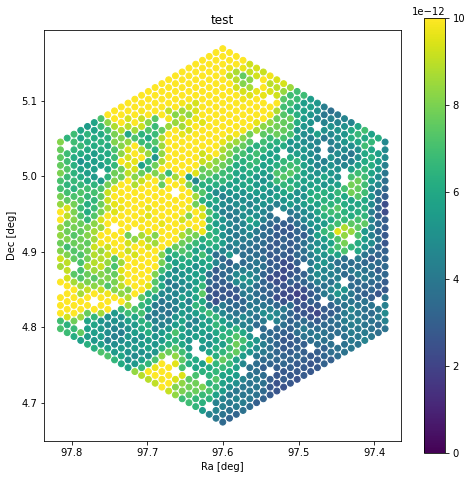

In [79]:
line_dict={}
line_dict['ra_fib'],line_dict['dec_fib'], line_dict['line'] = read_file_CFrame('00006109', '60222', nobad=True)
plotty(line_dict, -1e-16, 100000*1e-16, 'test', 'test', size=35)


In [61]:
plotty(line_dict, -1e-16, 100000*1e-16, 'test', 'test', size=35, nobad=True)

TypeError: plotty() got an unexpected keyword argument 'nobad'

In [40]:
print(line_dict['line'])

[3.4138729e-12 3.9689150e-12 4.4472637e-12 ... 6.9462595e-12 5.7735110e-12
 6.1977246e-12]
